In [1]:
# %load imports.ipy
# Stdlib
from functools import partial
from itertools import chain
from pprint import pprint as print

import numpy as np
import pandas as pd

pd.set_option('display.max_columns',102)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width',120)
import sklearn
print(f'numpy {np.__version__} pandas {pd.__version__} sklearn {sklearn.__version__}')

# Visualization

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

custom_style = {'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white', }
sns.set_style( rc=custom_style)
mpl.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.figsize']=(10,10)
jtplot.style('monokai')

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score

from genetic.estimator_parameters import params
from genetic.parameter_optimization import tune_params_genetic
from swozny_ml import benchmark_models, tune_params

# Config
# Custom stuff
from swozny_ml import *
from genetic.parameter_optimization import tune_params_genetic

def impute_logistic(data,target,scale,categorical,scoring):
    from sklearn.preprocessing import StandardScaler
    # Prepare data
    from copy import deepcopy
    prediction_params = scale+categorical
    training_cond = data[target].notnull()
    y_train = data[training_cond][target]

    _data=deepcopy(data)
    _data[scale]=StandardScaler().fit_transform(_data[scale])
    _data=pd.get_dummies(_data,columns=categorical,drop_first=True)
    prediction_params=[param for param in _data.columns if any(param.startswith(dummy) for dummy in prediction_params)]
    X_train = _data[training_cond][prediction_params]
    classifiers = [partial(LogisticRegression,multi_class='multinomial',solver='lbfgs')]
    benchmark = benchmark_models(classifiers, X_train, y_train, scoring=scoring)
    m=LogisticRegression(multi_class='multinomial',solver='lbfgs')
    m.fit(X_train,y_train)
    
    X_test = _data[~training_cond][prediction_params]
    data.loc[~training_cond,target]=m.predict(X_test)
    return data

from xgboost import XGBRegressor
def impute_linear(data,target,scale,categorical,scoring):
    from sklearn.preprocessing import StandardScaler
    # Prepare data
    from copy import deepcopy
    from sklearn.ensemble import GradientBoostingRegressor
    prediction_params = scale+categorical
    training_cond = data[target].notnull()
    y_train = data[training_cond][target]
    _data=deepcopy(data)
    _data[scale]=StandardScaler().fit_transform(_data[scale])
    _data=pd.get_dummies(_data,columns=categorical,drop_first=True)
    prediction_params=[param for param in _data.columns if any(param.startswith(dummy) for dummy in prediction_params)]
    X_train = _data[training_cond][prediction_params]
    classifiers = [partial(GradientBoostingRegressor,n_estimators=500)]
    benchmark = benchmark_models(classifiers, X_train, y_train, scoring=scoring)
    m=LinearRegression()
    m.fit(X_train,y_train)
    
    X_test = _data[~training_cond][prediction_params]
    data.loc[~training_cond,target]=m.predict(X_test)
    return data

'numpy 1.13.3 pandas 0.20.3 sklearn 0.19.0'


/home/swozny/untitled5/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Config

In [2]:
filename = 'datasets/houses.csv'
index = 'Id'
target = 'SalePrice'

In [3]:
# Read data
data = pd.concat([pd.read_csv(filename, index_col=index),pd.read_csv('datasets/houses_test.csv',index_col=index)])

data['MasVnrType']=data['MasVnrType'].fillna('None')
X=['Alley','MasVnrArea','BsmtFinType1','BsmtFinType2','BsmtCond','FireplaceQu','GarageCond','GarageArea','GarageCars',
   'GarageQual','GarageFinish','GarageType','PoolQC','MiscFeature','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtFullBath','BsmtHalfBath','BsmtQual','BsmtUnfSF','Fence']
for col in X:
    data[col]=data[col].fillna(0)
data['GarageYrBlt']=data[ 'GarageYrBlt'].fillna(data.GarageYrBlt.median())
data['Functional']=data['Functional'].fillna('Typ')
data['Utilities']=data['Utilities'].fillna('AllPub')
data['Exterior1st']=data['Exterior1st'].fillna('Other')
data['Exterior2nd']=data['Exterior2nd'].fillna('Other')
data['TotalBsmtSF']=data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['BsmtUnfSF']
data=impute_linear(data,'LotFrontage',['YearBuilt','LotArea'],['Neighborhood','MSSubClass','LotShape','SaleCondition','ExterCond','BldgType','MasVnrType','OverallQual','OverallCond','MSZoning'],'neg_mean_squared_error')
data=impute_logistic(data,'Electrical',['YearBuilt'],['Neighborhood','MSSubClass','RoofStyle','RoofMatl','SaleType','ExterCond','BldgType','MasVnrType','OverallQual','OverallCond','MSZoning'],'accuracy')
data=impute_logistic(data,'KitchenQual',['YearBuilt'],['Neighborhood','MSSubClass','RoofStyle','RoofMatl','SaleType','ExterCond','BldgType','MasVnrType','OverallQual','OverallCond','MSZoning'],'accuracy')
data=impute_logistic(data,'MSZoning',['YearBuilt'],['Neighborhood','MSSubClass','RoofStyle','RoofMatl','SaleType','ExterCond','BldgType','MasVnrType','OverallQual','OverallCond'],'accuracy')
data=impute_logistic(data,'SaleType',['YearBuilt'],['Neighborhood','MSSubClass','RoofStyle','RoofMatl','SaleCondition','ExterCond','BldgType','MasVnrType','OverallQual','OverallCond','MSZoning'],'accuracy')


Evaluating GradientBoostingRegressor              ... Score -295.13
Evaluating LogisticRegression              ...

/home/swozny/untitled5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


 Score 0.92
Evaluating LogisticRegression              ... Score 0.79
Evaluating LogisticRegression              ... Score 0.94
Evaluating LogisticRegression              ...

/home/swozny/untitled5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


 Score 0.94


In [4]:
data['PoolArea']

Id
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
       ..
2890    0
2891    0
2892    0
2893    0
2894    0
2895    0
2896    0
2897    0
2898    0
2899    0
2900    0
2901    0
2902    0
2903    0
2904    0
2905    0
2906    0
2907    0
2908    0
2909    0
2910    0
2911    0
2912    0
2913    0
2914    0
2915    0
2916    0
2917    0
2918    0
2919    0
Name: PoolArea, Length: 2919, dtype: int64

In [5]:
missing=data[[col for col in data.columns if data[col].isnull().any()]].drop('SalePrice',axis=1).columns
missing
(data['LotFrontage']>10e6).any()

True

## Categorical

In [6]:
# Categorical
categorical = data.select_dtypes(exclude=[np.number])
for col in categorical:
    data[col]=data[col].astype('category')
categorical = data.select_dtypes(exclude=[np.number])
categorical.describe()

,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Foundation,Functional,GarageCond,GarageFinish,GarageQual,GarageType,Heating,HeatingQC,HouseStyle,KitchenQual,LandContour,LandSlope,LotConfig,LotShape,MSZoning,MasVnrType,MiscFeature,Neighborhood,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
count,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919
unique,3,5,5,5,7,7,5,2,9,8,5,5,4,16,16,5,6,6,7,6,4,6,7,6,5,8,4,4,3,5,4,5,4,5,25,3,4,8,6,6,9,2,2
top,0,1Fam,TA,No,Unf,Unf,TA,Y,Norm,Norm,SBrkr,TA,TA,VinylSd,VinylSd,0,0,PConc,Typ,TA,Unf,TA,Attchd,GasA,Ex,1Story,TA,Lvl,Gtl,Inside,Reg,RL,None,0,NAmes,Y,0,CompShg,Gable,Normal,WD,Pave,AllPub
freq,2721,2425,2606,1904,851,2493,1283,2723,2511,2889,2672,2538,1798,1025,1014,2348,1420,1308,2719,2654,1230,2604,1723,2874,1493,1471,1493,2622,2778,2133,1859,2266,1766,2814,443,2641,2909,2876,2310,2402,2526,2907,2918


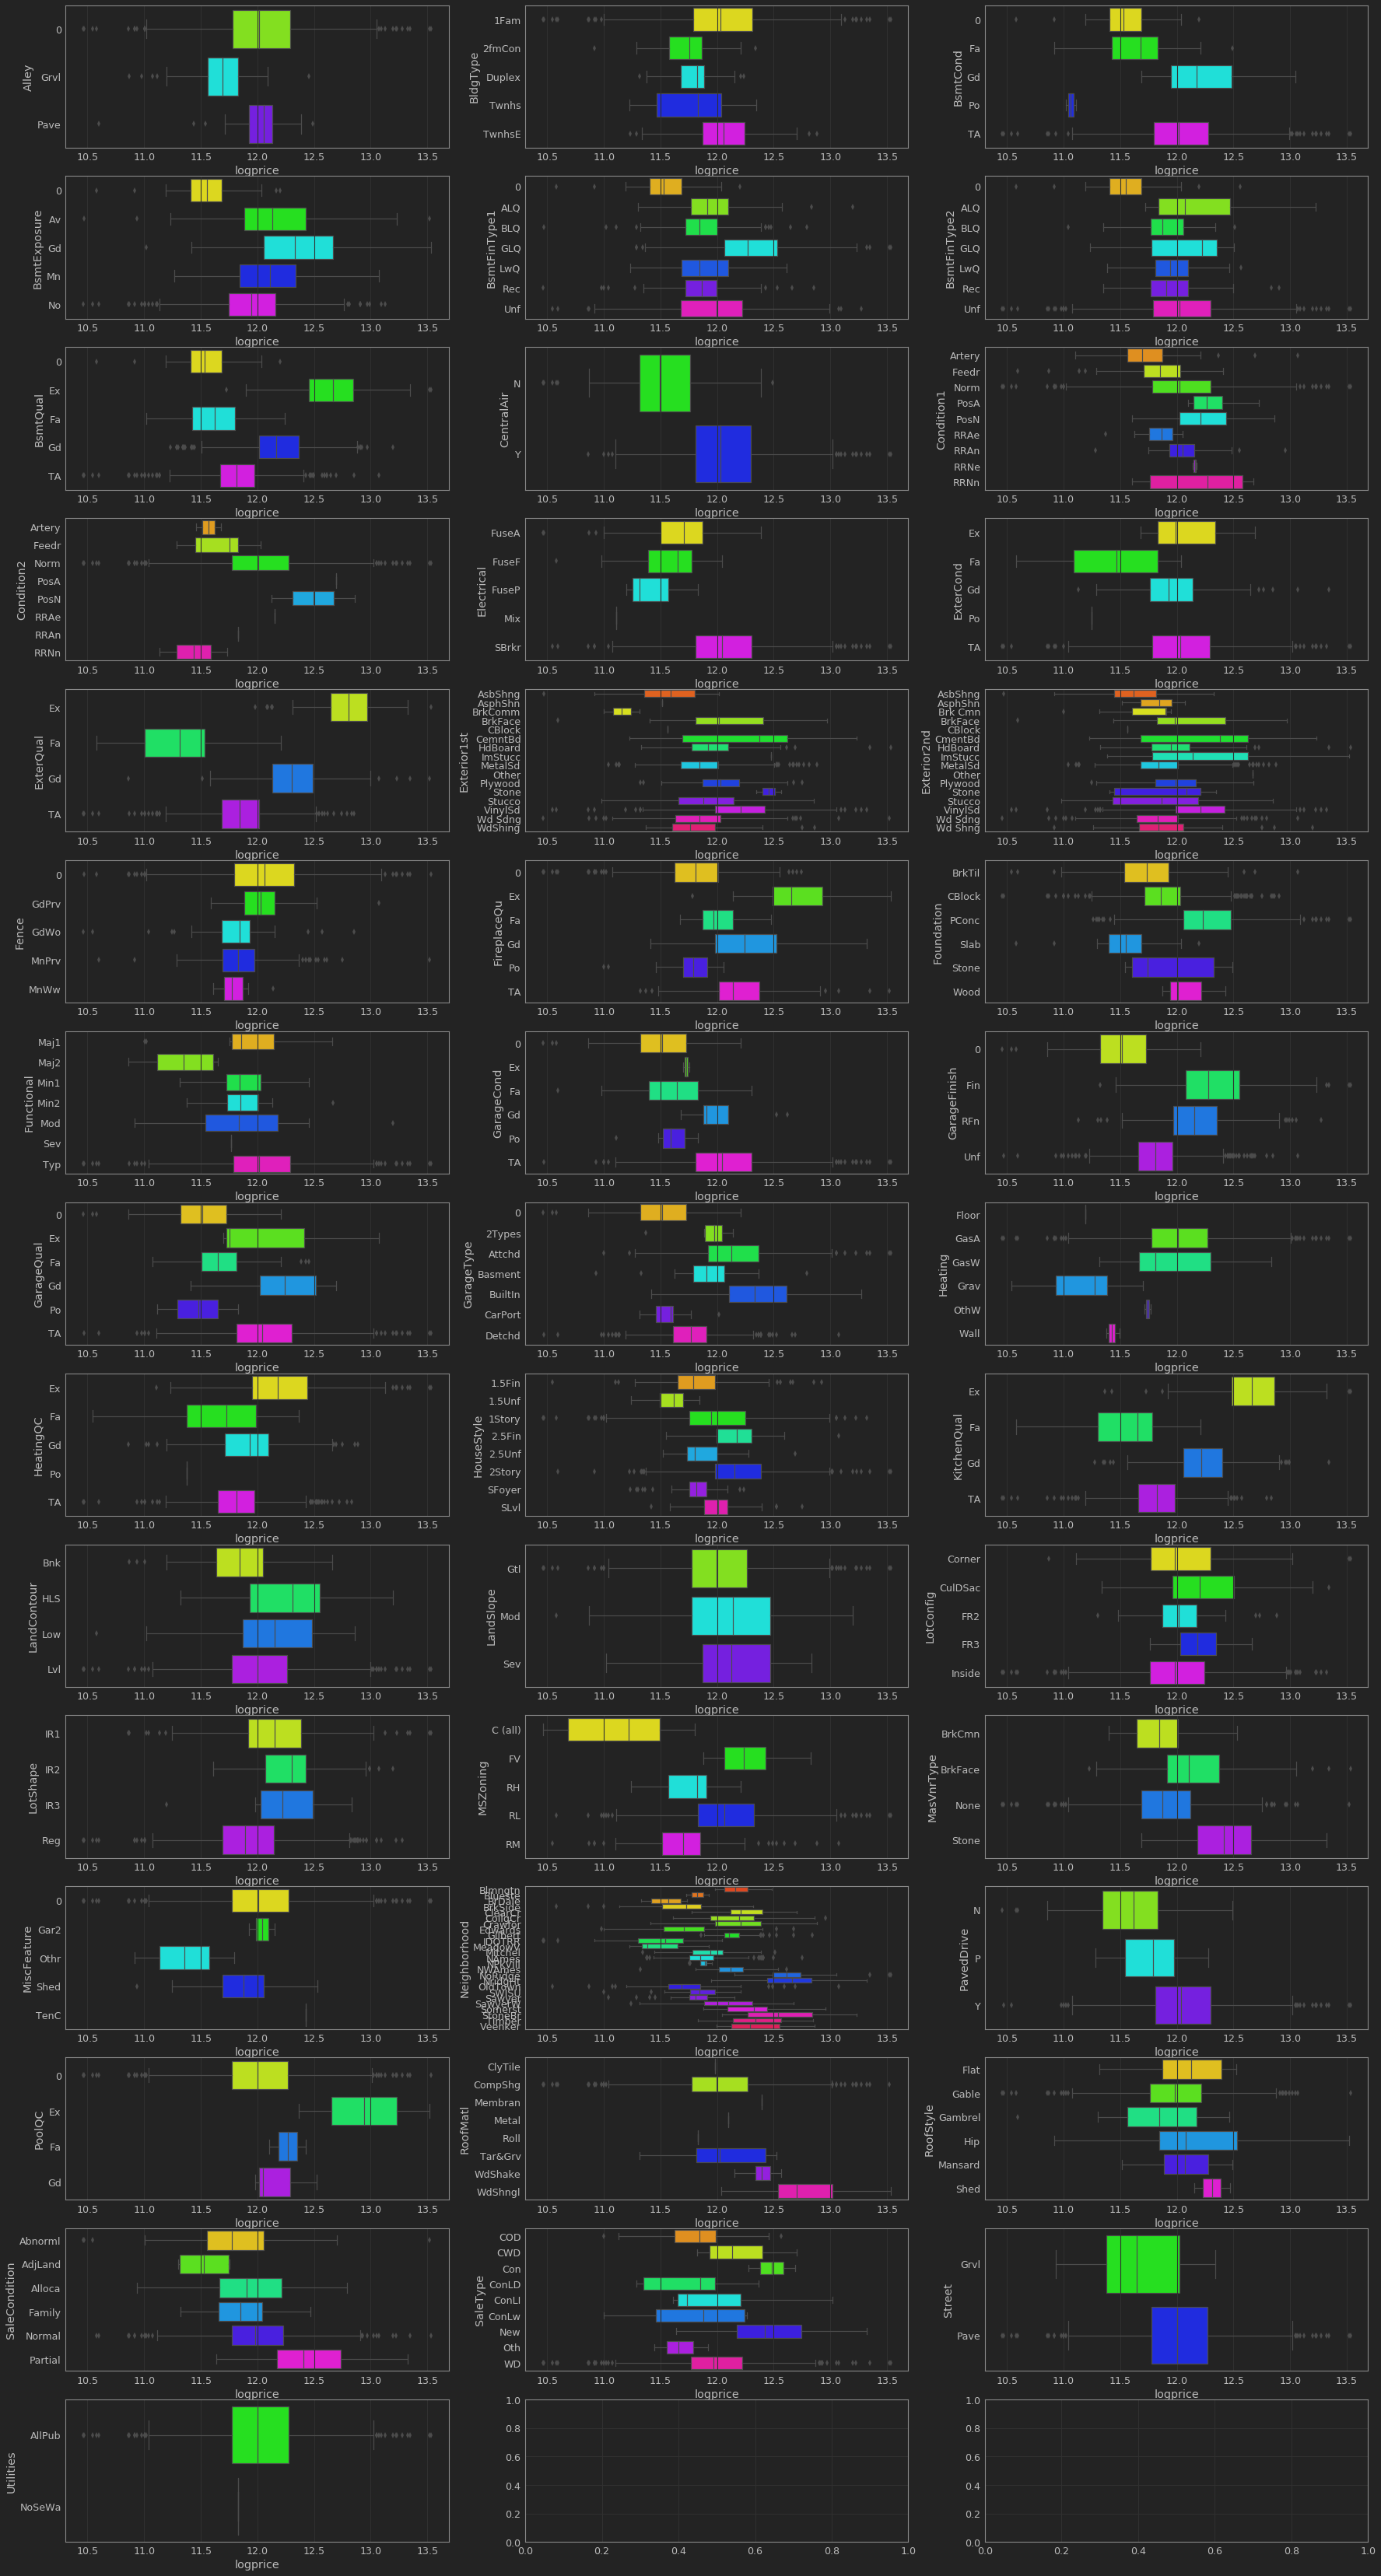

In [7]:
from math import ceil
data['logprice']=np.log(data[target])
fig, ax = plt.subplots(ncols=3,nrows=ceil(len(categorical.columns)/3),figsize=(30,60))
for col,ax in zip(categorical.columns,chain(*ax)):
    sns.factorplot(data=data,y=col,x='logprice',kind='box',ax=ax,color='white',palette='hsv')
    plt.close(2)

## Numerical

'Cutting values above 2288.020000000002 for 1stFlrSF. There are 30 many.'
'Cutting values above 1400.2000000000016 for 2ndFlrSF. There are 30 many.'
'Cutting values above 1635.2800000000007 for BsmtFinSF1. There are 30 many.'
'Cutting values above 874.6400000000003 for BsmtFinSF2. There are 30 many.'
'Cutting values above 1776.4600000000005 for BsmtUnfSF. There are 30 many.'
'Cutting values above 264.0 for EnclosedPorch. There are 28 many.'
'Cutting values above 1019.4600000000005 for GarageArea. There are 30 many.'
'Cutting values above 2009.0 for GarageYrBlt. There are 6 many.'
'Cutting values above 2935.7200000000075 for GrLivArea. There are 30 many.'
'Cutting values above 33038.64000000007 for LotArea. There are 30 many.'
'Cutting values above 134.82000000000016 for LotFrontage. There are 30 many.'
'Cutting values above 770.4600000000005 for MasVnrArea. There are 30 many.'
'Cutting values above 284.4600000000005 for OpenPorchSF. There are 30 many.'
'Cutting values above 442567.0100

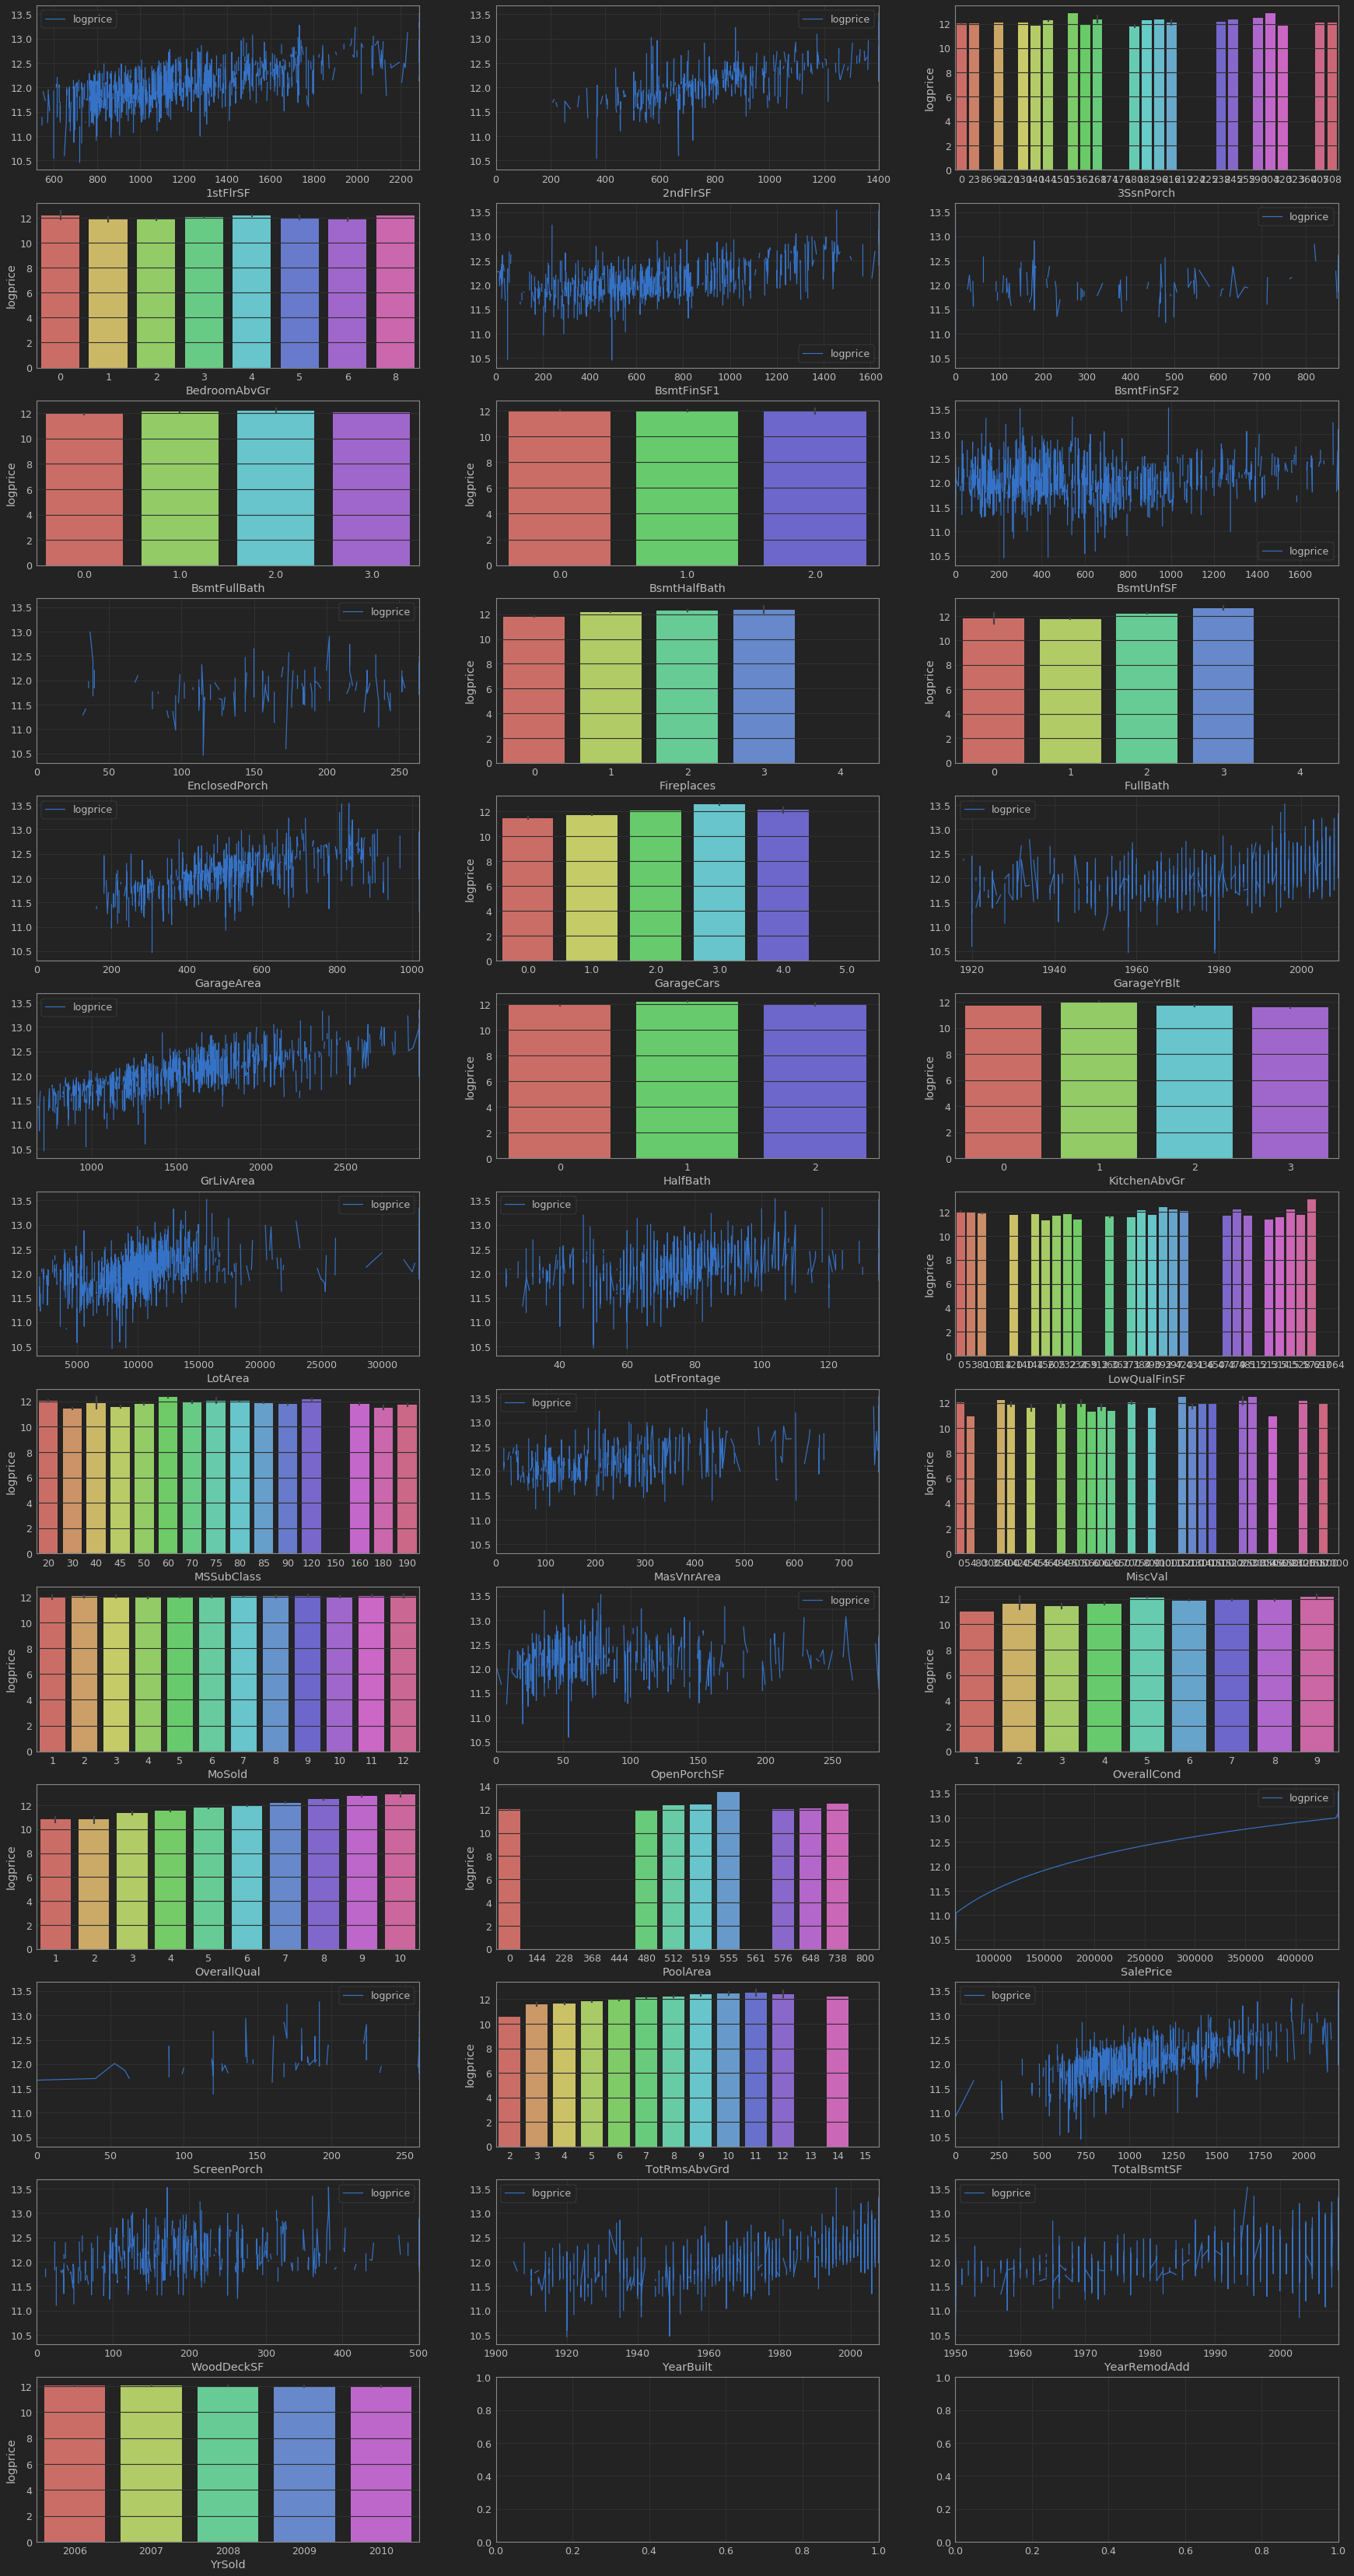

In [8]:
numerical = data.select_dtypes(include=[np.number])
fig, ax = plt.subplots(ncols=3,nrows=ceil(len(numerical.columns)/3),figsize=(30,60))
outliers = {}
for col,ax in zip(numerical.drop('logprice',axis=1).columns,chain(*ax)):
    if len(data[col].unique())<60:
        sns.factorplot(data=data,x=col,y='logprice',ax=ax,kind='bar',palette='hls')
        plt.close(2)
    else:
        cutoff=data[col].quantile(0.99)
        which=data[data[col]>cutoff]
        outliers[col]=which.index
        print(f'Cutting values above {cutoff} for {col}. There are {len(which)} many.')
        data[col]=data[col].clip(data[col].quantile(0.01),data[col].quantile(0.99))
        data.dropna(subset=[col]).sort_values(col).plot(y='logprice',x=col,ax=ax)

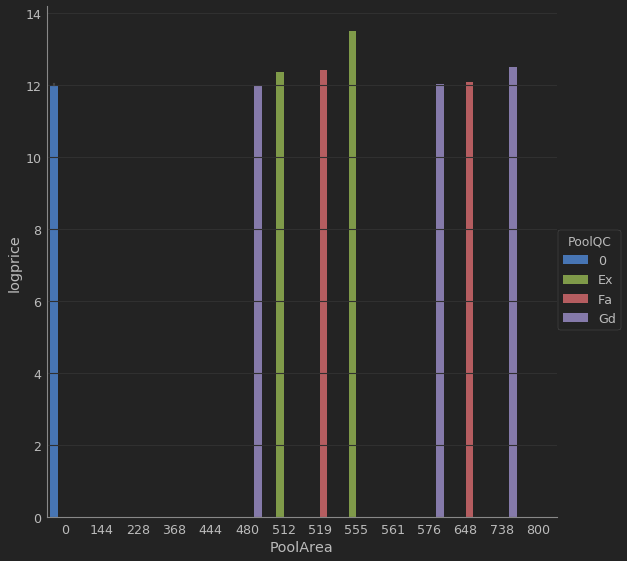

In [9]:
sns.factorplot(y='logprice',x='PoolArea',hue='PoolQC',data=data,kind='bar',size=8)

In [10]:
data[data.PoolArea>0][['PoolArea','logprice','PoolQC']].sort_values('PoolArea')

,PoolArea,logprice,PoolQC
Id,,,
1975,144,NaN,Ex
2574,228,NaN,Ex
2421,368,NaN,0
2504,444,NaN,0
1299,480,11.982929,Gd
198,512,12.367341,Ex
1387,519,12.429216,Fa
1183,555,13.521139,Ex
2600,561,NaN,0


In [ ]:
data=pd.get_dummies(data,columns=list(categorical.columns))
                    #+['OverallQual','OverallCond','TotRmsAbvGrd',"BedroomAbvGr","Fireplaces",'GarageCars','YrSold',
                     #                         'MSSubClass','KitchenAbvGr','HalfBath','FullBath','BsmtHalfBath','BsmtFullBath'])
data=data.drop(['SalePrice'],axis=1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
target='logprice'
cond=data[target].notnull()
X_train=data[cond].drop(target,axis=1)
y_train=data[cond][target]
from xgboost import XGBRegressor
m=XGBRegressor(n_estimators=800,learning_rate=0.03)
from sklearn.model_selection import GridSearchCV
best_models = tune_params([XGBRegressor],X_train,y_train,'neg_mean_squared_error')

Tuning XGBRegressor with {'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06], 'max_depth': [7, 9, 11], 'n_estimators': [100, 200, 300, 400, 500, 600, 700]}...


In [ ]:
m.fit(X_train,y_train)
X_test=data[~cond].drop(target,axis=1)
X_test[target]=m.predict(X_test)
X_test['SalePrice']=np.exp(X_test[target])
pred=X_test.SalePrice
pred.to_csv('predictions/houses.csv',header=True)

In [ ]:
data.groupby('Fireplaces').GarageArea.idxmax()